# Deterministic optimization of the solar home with Julia/JuMP

This notebook contains two optimization methods to minimize the grid energy cost $\sum_k c_{grid}(k).P_{grid}(k)$. The methods are *deterministic* in the sense that the uncertainty of the load and sun power is disregarded.

1. **Anticipative optimization** (also called *a posteriori* or *wait and see*): the entire time series of the test are used for the optimisation. This is equivalent to have a percfect forecast of the future. 

  - this yields the smallest physically possible cost
  - but it is not implementable (unless a perfect forecast is available)
  - a variant is implemented to minimize the grid energy rather than the cost

2. **Fixed optimization** + recourse, which works in two steps:

  1. the battery schedule is optimized for the entire duration of the test *based on the forecast* of load and sun power. 
  2. $P_{grid}$ and $P_{curt}$ are used as recourses to adjust to the actual of load and sun power

The fixed optimization is not useful by itself, but it is a building block for MPC and OLFC which also use forecast (but on a receding horizon).

Pierre Haessig - last update April 2020

In [1]:
using Printf, Statistics # for mean

# Optimization:
using JuMP
using Clp

# Plotting:
using PyPlot

Import solarhome utility module `Benchutils`, using `bu` as a short alias.

In [2]:
p_utils = joinpath("..","..","utils")
@assert isdir(p_utils)
push!(LOAD_PATH, p_utils)

import Benchutils
const bu = Benchutils

Benchutils

## 1. Load solar home data

In [3]:
params, data = bu.load_data(subset="test");

loading test data (2011-11-29 00:00:00 to 2011-12-28 23:30:00)

### 1.A. Solar home parameters (ratings)

Parameters are fields of the `params` struct:

In [4]:
println("E_rated: $(params.E_rated) kWh")
println("P_pvp: $(params.P_pvp) kWp")
println("P_grid_max: $(params.P_grid_max) kW")

E_rated: 8.0 kWh
P_pvp: 4.0 kWp
P_grid_max: 3.0 kW


### 1.B. Solar home time series

vectors for time, power inputs and grid price

Time vectors

In [5]:
t = data["t"] # hours
td = t/24; # days
dt = t[2] - t[1] # timestep, hours
dt

0.5

In [6]:
n = length(t)
ndays = Int(n/48) # days
ndays

30

Power inputs and price

In [7]:
P_load = data["P_load_sp"]
# scaling of PV production
P_sun = data["P_sun_1k"]*params.P_pvp;
c_grid = data["c_grid"];

In [8]:
@printf("Average sun energy: %.2f kWh/d\n", mean(P_sun)*24)
@printf("Average load      : %.2f kWh/d\n", mean(P_load)*24)
@printf("ratio sun/load: %.1f%%", mean(P_sun)/mean(P_load)*100)

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.7%

Demo plot of input data

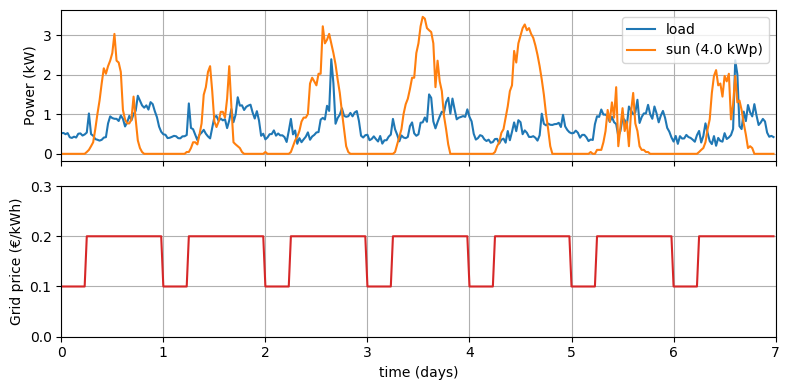

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4), sharex=true)
z = 1:7*48

# Power flow inputs:
ax1.plot(td[z], P_load[z], label="load", color="tab:blue")
ax1.plot(td[z], P_sun[z], label="sun ($(params.P_pvp) kWp)", color="tab:orange")

ax1.legend()
ax1.grid(true)

ax1.set(
    xlim = (0,7),
    ylabel = "Power (kW)"   
)

# Grid price
ax2.plot(td[z], c_grid[z], color="tab:red")

ax2.grid(true)

ax2.set(
    xlim = (0,7),
    ylim = (0,0.3),
    xlabel = "time (days)",
    ylabel = "Grid price (€/kWh)"   
)
fig.tight_layout()

### 1.C. Load forecast data

*TODO*: move this code to Benchutils?

In [10]:
using DelimitedFiles

In [11]:
cons_dpat, header = readdlm("../../data/daily_pattern_cons_M-1-2011-11-28.csv", ',', header=true)

hod = cons_dpat[:,1];
cons_dmean = cons_dpat[:,2];

prod_dpat, header = readdlm("../../data/daily_pattern_prod_M-1-2011-11-28.csv", ',', header=true)
prod_dmean = prod_dpat[:,2];
prod_dmean .*= params.P_pvp/1.04;

Repeat the daily pattern for each day of the test period

In [12]:
P_load_fc = repeat(cons_dmean, outer=ndays);
P_sun_fc = repeat(prod_dmean, outer=ndays);

Plot of the forecast (showing the periodic aspect)

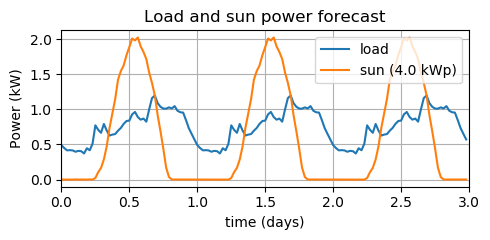

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,2.5))
ndp = 3 # nb of days to plot
z = 1:ndp*48
ax.plot(td[z], P_load_fc[z], label="load", color="tab:blue")
ax.plot(td[z], P_sun_fc[z], label="sun ($(params.P_pvp) kWp)", color="tab:orange")

ax.legend()
ax.grid(true)

ax.set(
    title="Load and sun power forecast",
    xlim = (0,ndp),
    xlabel = "time (days)",
    ylabel = "Power (kW)"   
)
fig.tight_layout()

## 2. Describe the optimization problems

Select the default optimization solver:

In [14]:
const default_optimizer = Clp.Optimizer
# set solver attributes: 
#const default_optimizer = optimizer_with_attributes(Clp.Optimizer, "LogLevel" => 0)

Clp.Optimizer

### 2.A. Anticipative optimization

Battery schedule (and all power flows) depend on the future data.

Also called *a posteriori* or *wait and see*.

Variant: minimize energy rather than the cost (with `cost=false`)

In [15]:
function optim_anticip(params, data, cost=true; optimizer=default_optimizer)
    E_rated = params.E_rated
    P_pvp = params.P_pvp
    P_grid_max = params.P_grid_max
    
    P_load = data["P_load_sp"]
    P_sun = data["P_sun_1k"]*params.P_pvp;
    c_grid = data["c_grid"];
    dt = data["t"][2] - data["t"][1]
    
    n = length(P_load)
    
    m = Model(optimizer)
    # silence solver output
    set_silent(m)
    
    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load[k])
        @constraint(m, P_curt[k] <= P_sun[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup
    
    if cost
        @objective(m, Min, sum(P_grid .* c_grid))
    else
        @objective(m, Min, sum(P_grid))
    end
    
    # Optimize and check result
    optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        
    else
        error("The model was not solved correctly.")
    end
    
    # trajectories of all variables
    traj = Dict(
        "E_sto" => value.(E)[1:end-1], # state 
        "P_sto" => value.(P_sto), # out

        "P_load_sp" => P_load,
        "P_shed" => zero(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => value.(P_curt),
        "P_pv"   => P_sun .- value.(P_curt),

        "P_grid" => value.(P_grid),
        "c_grid" => c_grid,
    )
    return traj
end

optim_anticip (generic function with 2 methods)

### 2.B. Fixed battery schedule + recourse

1. optimize battery schedule based on load & solar forecast (which is not perfect) 
2. then adjust to real load & solar with recourse P_grid and P_curt

helper: positive part function

In [16]:
pos(x) = x>0 ? x : 0.

pos (generic function with 1 method)

In [17]:
function optim_fixed(params, data, P_sun_fc, P_load_fc; optimizer=default_optimizer)
    E_rated = params.E_rated
    P_pvp = params.P_pvp
    P_grid_max = params.P_grid_max
    
    P_load = data["P_load_sp"]
    P_sun = data["P_sun_1k"]*params.P_pvp;
    c_grid = data["c_grid"];
    dt = data["t"][2] - data["t"][1]
    
    n = length(P_load)
    
    m = Model(optimizer)
    # silence solver output
    set_silent(m)

    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun_fc[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load_fc[k])
        @constraint(m, P_curt[k] <= P_sun_fc[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup

    @objective(m, Min, sum(P_grid .* c_grid))
    
    # Optimize and check result
    optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        
    else
        error("The model was not solved correctly.")
    end
    
    P_sto = value.(P_sto)
    # Recompute recourses for P_curt & P_diff
    # to adjust to actual P_sun & P_load values
    P_diff = P_sun - P_load .- P_sto # power mismatch
    P_curt = pos.(P_diff)
    P_grid = pos.(-P_diff)
    
    # trajectories of all variables
    traj = Dict(
        "E_sto" => value.(E)[1:end-1], # state 
        "P_sto" => P_sto, # out

        "P_load_sp" => P_load,
        "P_shed" => zero(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => P_curt,
        "P_pv"   => P_sun .- P_curt,

        "P_grid" => P_grid,
        "c_grid" => c_grid,
    )
    return traj
end

optim_fixed (generic function with 1 method)

## 3. Run and compare optimizations

In [18]:
traj_anticip = optim_anticip(params, data, true)
traj_anticip_en = optim_anticip(params, data, false) # minimize energy rather than the cost
traj_fixed = optim_fixed(params, data, P_sun_fc, P_load_fc);

### Performance statistics

Compute statistics over trajectories

In [19]:
stats_anticip = bu.compute_stats(traj_anticip)
stats_anticip_en = bu.compute_stats(traj_anticip_en)
stats_fixed = bu.compute_stats(traj_fixed);

Pretty print of stats

Anticipative optimization

In [20]:
bu.pprint_stats(stats_anticip)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.97 kWh/d
P_pv:      13.64 kWh/d

P_sto:      0.00 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.354 €/d


Anticipative optimization (energy rather than the cost)

In [22]:
bu.pprint_stats(stats_anticip_en)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.97 kWh/d
P_pv:      13.64 kWh/d

P_sto:      0.00 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.631 €/d


Fixed optimization 

In [23]:
bu.pprint_stats(stats_fixed)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     5.31 kWh/d
P_pv:      10.29 kWh/d

P_sto:     -0.00 kWh/d

P_grid:     6.73 kWh/d
C_grid:    1.015 €/d


#### Observations on performance statistics

* **Anticipative optimization**: 0.354 €/d, with <P_grid> 3.38 kWh/d.

  * Observation: minimizing the grid *energy* instead of the *cost* yields the same energy consumption (but at a higher cost: 0.631 €/d)
  * Interpretation: cost optimization is performed only by *displacing the grid consumption* (e.g., there are many solutions which yields the same energy consumption)

* **Fixed optimization**: 1.015 €/d, with <P_grid> 6.73 kWh/d.

  * performance of this method is pretty bad!
  * in particular, a lot of solar energy is wasted → high grid energy consumption

* *For the reference*, **rule-based control** yields 0.563 €/d, with <P_grid> 3.38 kWh/d

  * Interpretation: 3.38 kWh/d is a minimum which is easy to achieve
  * Minimizing the cost (with time-variying price) is however more difficult and some anticipation helps.

#### Analysis of grid price

Average grid price paid by each method (should be between 0.10 and 0.20 €/kWh, the range of $c_{grid}$)

In [24]:
0.563/3.38 # rule-based control

0.1665680473372781

In [25]:
0.354/3.38 # anticipative optim (cost)

0.10473372781065088

In [27]:
1.015/6.73 # fixed optim

0.15081723625557203

In [28]:
0.631/3.38 # anticipative optim (energy rather than cost)

0.18668639053254438

Observation: the solution which minimizes the cost yields a average energy price **very close to the night price**.

### Plots

#### Anticipative optimization

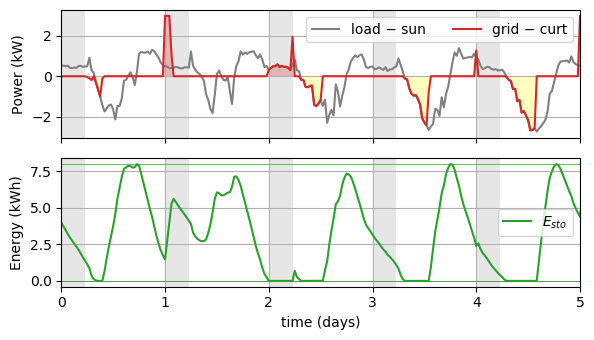

In [29]:
fig, ax = bu.plot_traj(traj_anticip, params.E_rated)
ax[1].set_xlim(0, 5);

#### Fixed optimization + recourse

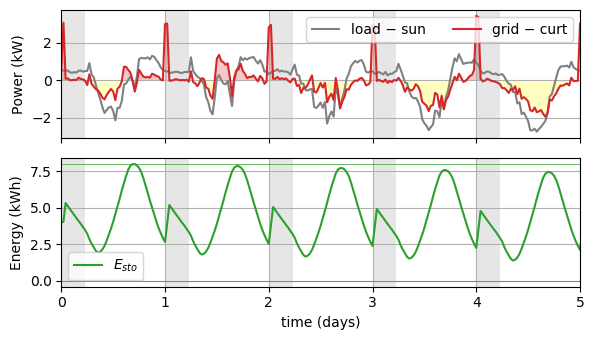

In [30]:
fig, ax = bu.plot_traj(traj_fixed, params.E_rated)
ax[1].set_xlim(0, 5);

Comparison of cumulated grid energy for anticipative optimization methods (cost vs. energy minimization): at the end it is the same (3.38 kWh/d → 101 kWh on 30 days)

In [31]:
stats_anticip["P_grid"]*ndays, stats_anticip_en["P_grid"]*ndays

(101.34053846153847, 101.34053846153847)

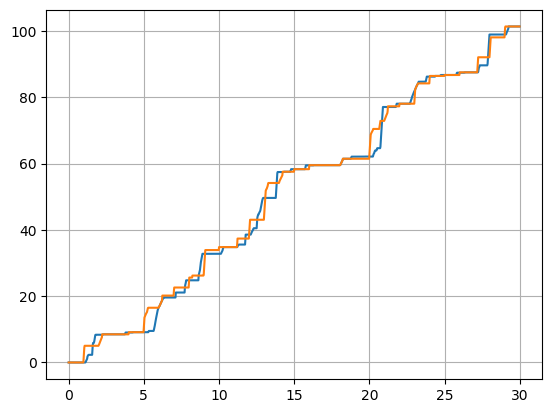

In [32]:
plot(td, cumsum(traj_anticip_en["P_grid"])*dt)
plot(td, cumsum(traj_anticip["P_grid"])*dt)
grid(true)

### Save results in CSV file

In [33]:
bu.save_results("Julia_anticipative-optim", params, data, stats_anticip, traj_anticip)

result files for method "Julia_anticipative-optim" written!


In [34]:
bu.save_results("Julia_anticipative-optim-en", params, data, stats_anticip_en, traj_anticip_en)

result files for method "Julia_anticipative-optim-en" written!


In [35]:
bu.save_results("Julia_fixed-optim", params, data, stats_fixed, traj_fixed)

result files for method "Julia_fixed-optim" written!
